# Up/Down decon with stochastic gradient algorithms and multiple virtual sources - comparison of torch vs numpy

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt,convolve, hilbert
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from stochmdd_numpy import SGD, ExponentialLR, MDDminibatch
from stochmdd import MDDminibatch as MDDminibatch_torch

## Data loading

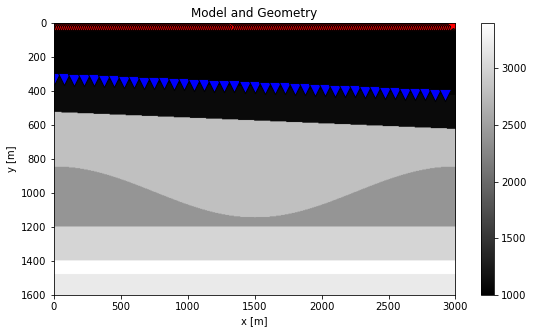

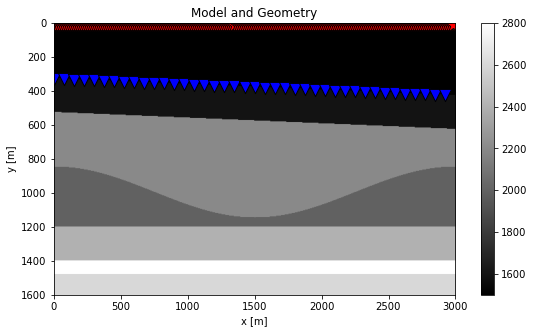

In [2]:
datapath = 'Data'

inputfile = os.path.join(datapath, 'input_dipping_recsolid.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1600.0 # velocity at separation level
rho_sep = 1100.0 # density at separation level
method = 'src_ana'


inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
r = r[:, 201:-1]
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
s = s[:, :200]
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 941, 0.005
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

plt.figure(figsize=(9,5))
im = plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

Up/down separated data

In [3]:
data = np.load('Data/updown_dipping_belowseabed_%s.npz'% method)

pup = data['pup'][:200, :, :200]
pdown = data['pdown'][:200, :, :200]

Reference Reflection response

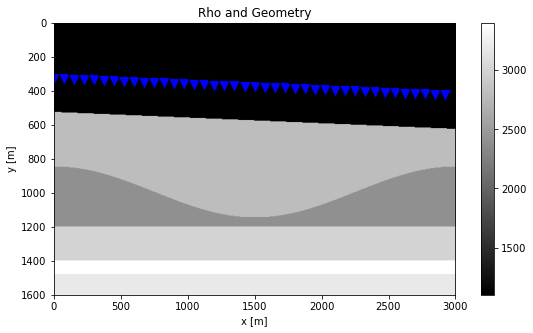

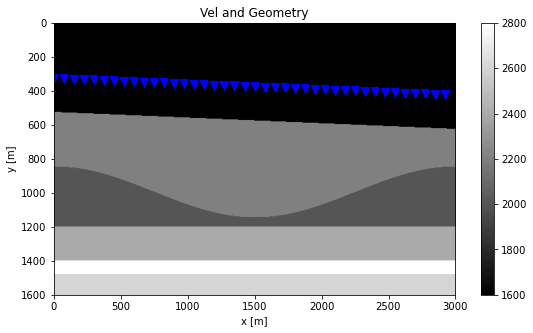

In [4]:
inputfile = os.path.join(datapath, 'input_dipping_noseabed_recsolid.npz')
inputdata = np.load(inputfile)

# data
R = -inputdata['vz_noseabed'][:, :200]

# Model
rho_ref = inputdata['rho_noseabed']
vel_ref = inputdata['vel_noseabed']

plt.figure(figsize=(9,5))
im = plt.imshow(rho_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Rho and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Vel and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

## Data preparation

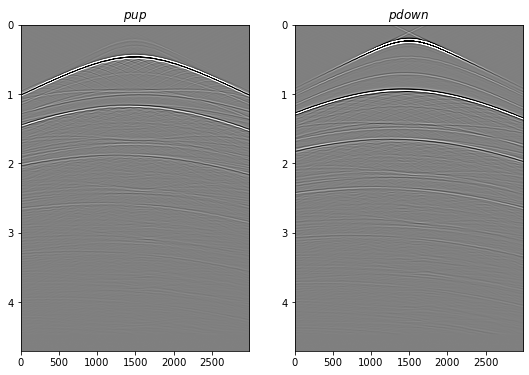

In [5]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50 # 400
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
R = np.pad(R, ((1, npad), (0, 0) ))#.astype('float32')
ntpad = pup.shape[1]
tpad = np.arange(ntpad) * dt
tpad2 = np.hstack((-tpad[::-1], tpad[1:]))

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight');

In [6]:
# Rescale data to of amplitude around 1
scaling = 5
pdown *= scaling
pup *= scaling

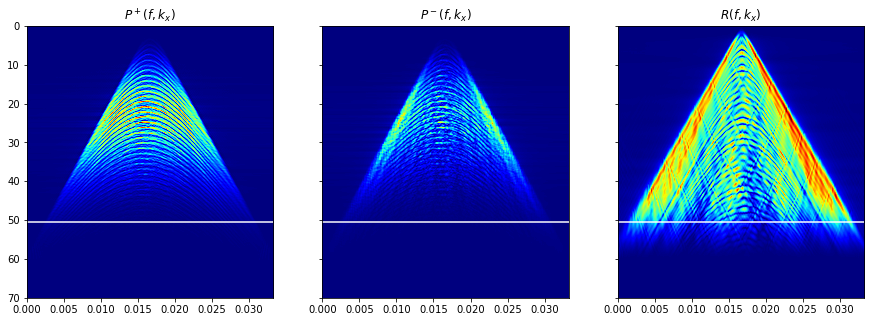

In [7]:
# check max frequency to use
nfmax=250#550
nfft = ntpad#2**11

FFTop = FFT2D(dims=[nr, ntpad], nffts=[nfft, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[ns//2].T.flatten()).reshape(nfft, nfft)
RTRUE = (FFTop*R.T.ravel()).reshape(nfft, nfft)

# mask away high freqs
mask = np.zeros((nfft, nfft))
mask[:, :nfmax] = 1
mask[:, -nfmax:] = 1
mask = filtfilt(np.ones(50)/50, 1, mask, axis=1)
RTRUE *= mask
R = np.real(FFTop.H * RTRUE.ravel()).reshape(nr, ntpad).T

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight')
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[nfmax], color='w')
axs[2].set_title(r'$R(f, k_x)$')
axs[2].axis('tight')
axs[2].set_ylim(70, 0);

## Stochastic MDD

In [8]:
lossdict = {}
lossepochdict = {}
avgdict = {}
enormdict = {}
mdict = {}
dr = 1. # force it to 1

In [9]:
# all vs
ivs = nr//2
nvsin = 0
nvsend = nr
nvs = nvsend-nvsin
nvs

200

In [10]:
pup = pup[:, :, nvsin:nvsend].transpose(1, 0, 2)
pdown = pdown.transpose(1, 0, 2)

In [11]:
pdown_fft = np.fft.rfft(pdown, ntpad, axis=0)
pdown_fft = pdown_fft[:nfmax]

In [12]:
# Torch
R_torch= torch.from_numpy(R)
pdown_fft_torch = torch.from_numpy(pdown_fft)
pup_torch = torch.from_numpy(pup)

### Gradients

Initial Loss norm: 2.009957e+00
Initial Gradient norm: 2.492053e-02, scaled by lr: 2.492053e-02
Time: 16.111460 s
Initial Gradient norm: 9.958157e-06, scaled by lr: 9.958157e-06
Initial Gradient norm as np.linalg.norm: 6.254508e+04, scaled by nbatches:  6.254508e+04
Final Model norm: 9.958157e-06
Time: 23.093647 s


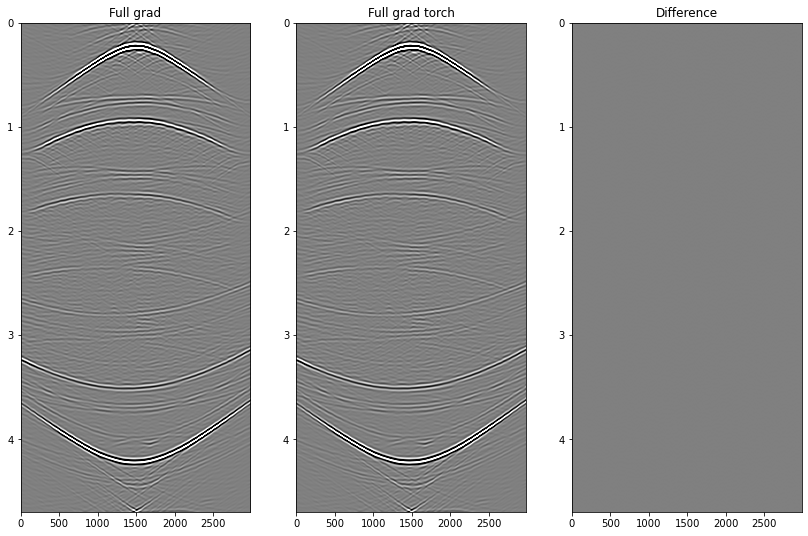

In [13]:
# Check full gradient
gradfull = MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                        1, ns, twosided=False, mtrue=R, ivstrue=ivs, seed=0, savegradnorm=True, savefirstgrad=True,
                        **dict(lr=1., weight_decay=0))[-1].reshape(ntpad, nr, nvs)
gradfull_torch = MDDminibatch_torch(ntpad, nr, dt, dr, pdown_fft_torch, pup_torch, torch.optim.SGD, 
                        1, ns, twosided=False, mtrue=R_torch, ivstrue=ivs, seed=0, savegradnorm=True, savefirstgrad=True,
                        **dict(lr=1., weight_decay=0))[-1].reshape(ntpad, nr, nvs)

torch_to_numpy_to_scaling =  ((ntpad*ns*nvs)/2) 
gradfull_torch = gradfull_torch * torch_to_numpy_to_scaling

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
axs[0].imshow(gradfull[..., ivs], cmap='gray', vmin=-0.1*np.abs(gradfull).max(), vmax=0.1*np.abs(gradfull).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'Full grad')
axs[0].axis('tight')
axs[1].imshow(gradfull_torch[..., ivs], cmap='gray', vmin=-0.1*np.abs(gradfull).max(), vmax=0.1*np.abs(gradfull).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'Full grad torch')
axs[1].axis('tight')
axs[2].imshow(gradfull[..., ivs] - gradfull_torch[..., ivs].cpu().numpy(), cmap='gray', vmin=-0.1*np.abs(gradfull).max(), vmax=0.1*np.abs(gradfull).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'Difference')
axs[2].axis('tight');

Initial Loss norm: 1.861656e+00
Initial Gradient norm: 2.948048e-03, scaled by lr: 2.948048e-03
Time: 46.819698 s
Initial Gradient norm: 4.601678e-05, scaled by lr: 4.601678e-05
Initial Gradient norm as np.linalg.norm: 2.151205e+04, scaled by nbatches:  1.344503e+05
Final Model norm: 5.209427e-04
Time: 57.479443 s


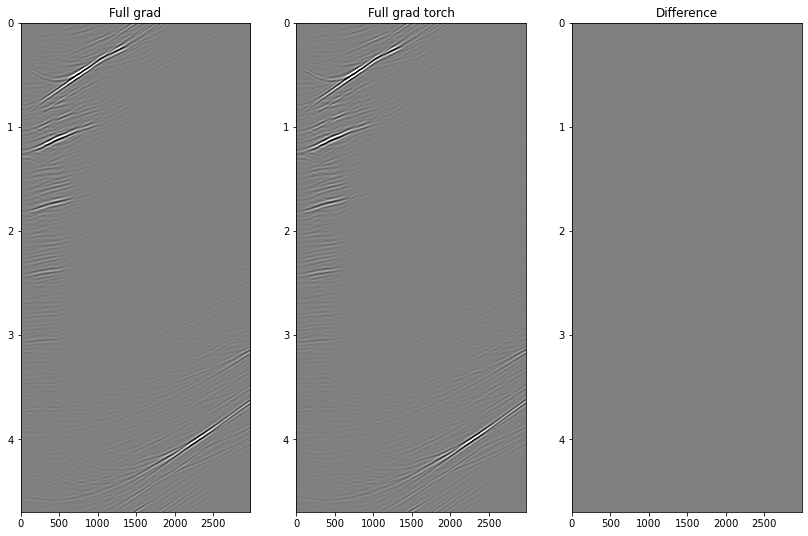

In [14]:
# Check Batch
batch_size = 32

grad32 = MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                      1, batch_size, twosided=False, shuffle=False, mtrue=None, seed=0, savegradnorm=True, savefirstgrad=True,
                      **dict(lr=1., weight_decay=0))[-1].reshape(ntpad, nr, nvs)
grad32_torch = MDDminibatch_torch(ntpad, nr, dt, dr, pdown_fft_torch, pup_torch, torch.optim.SGD, 
             1, batch_size, twosided=False, shuffle=False, mtrue=None, seed=0, savegradnorm=True, savefirstgrad=True,
             **dict(lr=1., weight_decay=0))[-1].reshape(ntpad, nr, nvs)

torch_to_numpy_to_scaling = ((ntpad*batch_size*nvs)/2) 
grad32_torch = grad32_torch * torch_to_numpy_to_scaling


fig, axs = plt.subplots(1, 3, figsize=(14, 9))
axs[0].imshow(grad32[..., ivs], cmap='gray', vmin=-0.1*np.abs(gradfull).max(), vmax=0.1*np.abs(gradfull).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'Full grad')
axs[0].axis('tight')
axs[1].imshow(grad32_torch[..., ivs], cmap='gray', vmin=-0.1*np.abs(gradfull).max(), vmax=0.1*np.abs(gradfull).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'Full grad torch')
axs[1].axis('tight')
axs[2].imshow(grad32[..., ivs] - grad32_torch[..., ivs].cpu().numpy(), cmap='gray', vmin=-0.1*np.abs(gradfull).max(), vmax=0.1*np.abs(gradfull).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'Difference')
axs[2].axis('tight');

### SGD with no shuffle

In [15]:
batch_size = 64
nepochs = 1
lr_torch = 1500.

In [16]:
torch_to_numpy_to_scaling = ((ntpad*batch_size*nvs)/2) 
lr = lr_torch / torch_to_numpy_to_scaling

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                              nepochs, batch_size, twosided=False, shuffle=False,
                              mtrue=None, seed=0, enormabsscaling=True,
                              epochprint=5, savegradnorm=True, 
                              **dict(lr=lr, weight_decay=0))
mdict["SGD"] = model

Initial Loss norm: 1.936968e+00
Initial Gradient norm: 6.595883e-03, scaled by lr: 3.689336e-10
Time: 57.445486 s


In [21]:
model, dmod, lossdict['SGD_torch'], avgdict['SGD_torch'], lossepochdict['SGD_torch'], enormdict['SGD_torch'], _ = \
                 MDDminibatch_torch(ntpad, nr, dt, dr, pdown_fft_torch, pup_torch, torch.optim.SGD, 
                                    nepochs, batch_size, twosided=False, shuffle=False,
                                    mtrue=None, seed=0, epochprint=5,
                                    **dict(lr=lr_torch, weight_decay=0))
mdict["SGD_torch"] = model.detach().numpy()

Initial Gradient norm: 2.573918e-05, scaled by lr: 5.791315e+01
Initial Gradient norm as np.linalg.norm: 3.217740e+04, scaled by nbatches:  1.005544e+05
Final Model norm: 8.974420e+02
Time: 75.166942 s


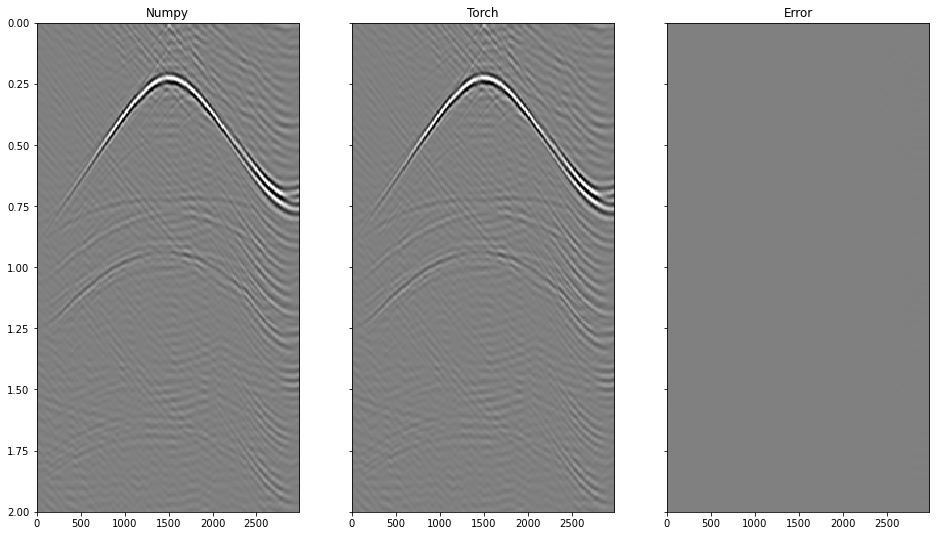

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(mdict["SGD"][..., ivs], 
           aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Numpy')
ax2.imshow(mdict["SGD_torch"][..., ivs],
           aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Torch')
ax3.imshow((mdict["SGD"][..., ivs]-mdict["SGD_torch"][..., ivs]),
           aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Error')
ax3.set_ylim(2, 0);

### SGD with momentum and no-shuffle

In [23]:
batch_size = 64
nepochs = 1
lr_torch = 500.

In [24]:
torch_to_numpy_to_scaling = ((ntpad*batch_size*nvs)/2) 
lr = lr_torch / torch_to_numpy_to_scaling

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                              nepochs, batch_size, twosided=False, shuffle=False,
                              mtrue=None, seed=0, enormabsscaling=True,
                              epochprint=5, savegradnorm=True, 
                              **dict(lr=lr, weight_decay=0, momentum=0.9, nesterov=True))
mdict["SGD"] = model

model, dmod, lossdict['SGD_torch'], avgdict['SGD_torch'], lossepochdict['SGD_torch'], enormdict['SGD_torch'], _ = \
                 MDDminibatch_torch(ntpad, nr, dt, dr, pdown_fft_torch, pup_torch, torch.optim.SGD, 
                                    nepochs, batch_size, twosided=False, shuffle=False,
                                    mtrue=None, seed=0, epochprint=5,
                                    **dict(lr=lr_torch, weight_decay=0, momentum=0.9, nesterov=True))
mdict["SGD_torch"] = model.detach().numpy()

Initial Loss norm: 1.936968e+00
Initial Gradient norm: 6.595883e-03, scaled by lr: 4.099262e-11
Time: 32.776983 s
Initial Gradient norm: 2.573918e-05, scaled by lr: 6.434794e+00
Initial Gradient norm as np.linalg.norm: 3.217740e+04, scaled by nbatches:  1.005544e+05
Final Model norm: 2.746709e+02
Time: 41.243581 s


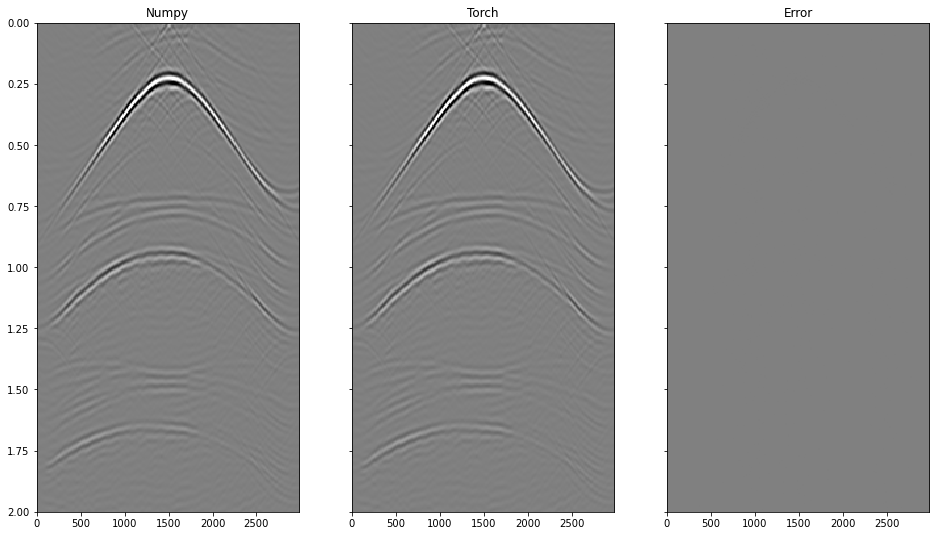

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(mdict["SGD"][..., ivs], 
           aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Numpy')
ax2.imshow(mdict["SGD_torch"][..., ivs],
           aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Torch')
ax3.imshow((mdict["SGD"][..., ivs]-mdict["SGD_torch"][..., ivs]),
           aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Error')
ax3.set_ylim(2, 0);